# 1. PCA

In [3]:
# import packages
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist, squareform
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from matplotlib import cm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [4]:
# set a PCA for the two principal components
my_pca = PCA(n_components=2)

In [5]:
# get the data
wines = pd.read_csv("/Users/ThomasBayzelon/IdeaProjects/Python Work/Assignments/wines_properties.csv")

In [6]:
# generate the projected data
new_projected_wines = my_pca.fit_transform(wines)

### 1.1. Ploting the Circle

In [7]:
def circle_plot(pca_obj,num1=1,num2=2):

    # Get the PCA components (Factor loadings)
    PCs = pca_obj.components_

    # Use quiver to generate the basic plot
    fig = plt.figure(figsize=(7,7))
    plt.quiver(np.zeros(PCs.shape[1]), np.zeros(PCs.shape[1]),
               PCs[num1-1,:], PCs[num2-1,:],
               angles='xy', scale_units='xy', scale=1)

    # Add labels based on feature names (here just numbers)
    #feature_names = np.arange(PCs.shape[1])
    #for i,j,z in zip(PCs[1,:]+0.075, PCs[0,:]+0.075, feature_names):
    #    plt.text(j, i, z, ha='center', va='center', fontsize=14, fontweight='bold')

    # Add unit circle
    circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='g', linewidth=2)
    plt.gca().add_artist(circle)

    # Ensure correct aspect ratio and axis limits
    plt.axis('equal')
    plt.xlim([-1.2,1.2])
    plt.ylim([-1.2,1.2])

    # Other stuff
    plt.xlabel('PC ' + str(num1))
    plt.ylabel('PC ' + str(num2))
    plt.grid(color='black', linestyle=':', linewidth=0.5)
    plt.title('Principal Components {num1} and {num2}'.format(num1=num1, num2=num2))

    # Done
    plt.show()

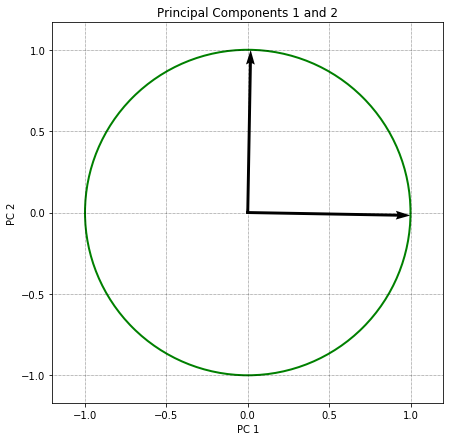

In [8]:
circle_plot(my_pca)

# 2. K-Means Analysis (Hierarchical)

In [9]:
# distance between units
row_dist = pd.DataFrame(squareform(pdist(wines, metric='euclidean')))

In [10]:
row_clusters = linkage(pdist(wines, metric='euclidean'), method='complete')

pd.DataFrame(row_clusters,
             columns=['row label 1', 'row label 2',
                      'distance', 'no. of items in clust.'],
             index=['cluster %d' % (i + 1) 
                    for i in range(row_clusters.shape[0])]).head()

,row label 1,row label 2,distance,no. of items in clust.
cluster 1,160.0,165.0,2.610709,2.0
cluster 2,67.0,106.0,2.654713,2.0
cluster 3,13.0,50.0,2.949610,2.0
cluster 4,8.0,9.0,3.270076,2.0
cluster 5,101.0,119.0,3.479253,2.0


### 2.1. Dendogram

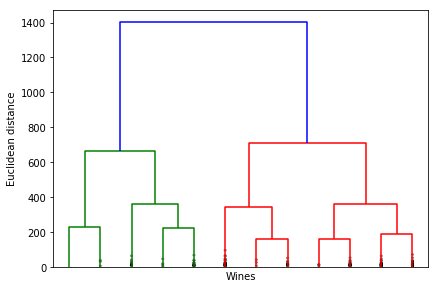

In [11]:
# Draw a dendogram that shows the last p merges
row_dendr = dendrogram(row_clusters,
                       truncate_mode='lastp',
                       p=12,
                       show_contracted=True,
                       distance_sort=False,
                       no_labels=True)
plt.tight_layout()
plt.xlabel('Wines')
plt.ylabel('Euclidean distance')
plt.show()

### 2.2. Elbow Rule

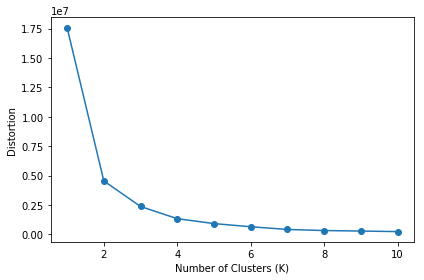

In [12]:
distortions = []
for i in range(1, 11):
    km = KMeans(n_clusters=i, 
                init='random', 
                n_init=10, 
                max_iter=300,
                tol=1e-04,
                random_state=0)
    km.fit(wines)
    distortions.append(km.inertia_)
    
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Distortion')
plt.tight_layout()
plt.show()

### 2.3. Silhouette Method

In [13]:
def best_silhouette(data):
    
    avg_clust = []

    for i in range(2,data.shape[0]//10):
        # maximum number of clusters -> one tenth of the sample
        # minimum number of clusters -> 2

        clusterer = KMeans(n_clusters=i, 
                init='random', 
                n_init=10, 
                max_iter=300,
                tol=1e-04,
                random_state=0)

        cluster_labels = clusterer.fit_predict(wines)

        silhouette_avg = silhouette_score(data, cluster_labels)

        avg_clust.append(silhouette_avg)

    num_clust = np.argmax(avg_clust) + 2
    
    return num_clust

num_clust = best_silhouette(wines)

print("The silhouette method suggests optimality at",num_clust,"clusters.")

The silhouette method suggests optimality at 2 clusters.


# 3. K-Means Analysis

In [14]:
# setting parameters
km = KMeans(n_clusters=num_clust, 
            init='random', 
            n_init=10, 
            max_iter=300,
            tol=1e-04,
            random_state=0)

In [15]:
y_km = km.fit_predict(wines)

### 3.1. Silhouette

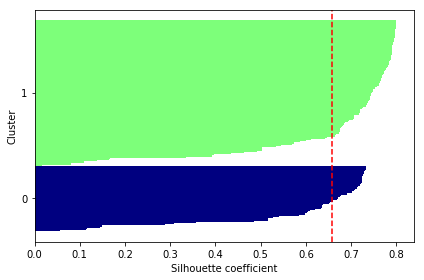

In [16]:
cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]

silhouette_vals = silhouette_samples(wines, y_km, metric='euclidean')

y_ax_lower, y_ax_upper = 0, 0
yticks = []

for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, 
             edgecolor='none', color=color)

    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)
    
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color="red", linestyle="--") 

plt.yticks(yticks, cluster_labels)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')

plt.tight_layout()
plt.show()

### 3.2. Plotting K-Means in the PCA Space

In [17]:
def twodimensions_plot(data,new_projected_data):
    
    # classification based on the wines space; plotting based on the new_project_wines
    
    # setting parameters
    km = KMeans(n_clusters=num_clust, 
                init='random', 
                n_init=10, 
                max_iter=300,
                tol=1e-04,
                random_state=0)

    # finding the centroids in the wines space
    y_km = km.fit_predict(data)
    km.cluster_centers_

    plt.scatter(new_projected_data[y_km == 0, 0],
                new_projected_data[y_km == 0, 1],
                s=50,
                c='blue',
                edgecolor='black',
                marker='s',
                label='Cluster 0')

    plt.scatter(new_projected_data[y_km == 1, 0],
                new_projected_data[y_km == 1, 1],
                s=50,
                c='lightgreen',
                edgecolor='black',
                marker='o',
                label='Cluster 1')

    # finding the centroids in the new_projected_wines space
    y_km = km.fit_predict(new_projected_data)

    plt.scatter(km.cluster_centers_[:, 0],
                km.cluster_centers_[:, 1],
                s=250, marker='*',
                c='red', edgecolor='black',
                label='Centroids')

    plt.legend()
    plt.grid(color='black', linestyle=':', linewidth=0.5)
    plt.tight_layout()
    plt.show()

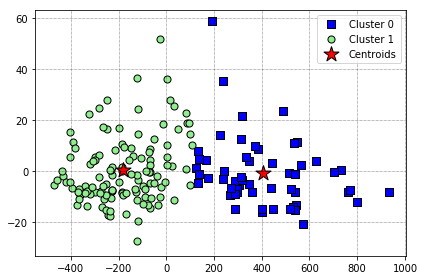

In [18]:
twodimensions_plot(wines,new_projected_wines)

### 3.3. Centroid (Barycenter)

In [19]:
# calculate the barycenter for each cluster
wines["Cluster"]=km.fit_predict(wines)
wines.groupby("Cluster").mean()

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline,Customer_Segment
Cluster,,,,,,,,,,,,,,
0,13.666545,1.870727,2.427818,17.452727,106.290909,2.816182,2.896545,0.292909,1.896909,5.520364,1.066655,3.066727,1151.727273,1.109091
1,12.702846,2.544553,2.339106,20.408130,96.813008,2.062114,1.641463,0.392683,1.454065,4.851382,0.908618,2.408211,565.869919,2.308943


#### 3.3.1. Interpretation

Cluster 0:
- More alcohol
- Less malic acid
- More ash
- Less ash alcanity
- More magnesium
- More phenols
- More flavanoids
- Less nonflavanoid phenols
- More proanthocyanins
- More color intensity
- More hue
- More OD280
- More proline
- Less customer segment

Cluster1:
- Vice-versa

# 4. Functions

# 4.1. K-Means Function
- Input = Dataset
- Output = K (i.e. number of clusters), plot of clusters in the first two dimensions of PCA

In [20]:
def auto_km(data):
    
    # import packages
    # ***The packages have already been imported in the previous items***
    # ***Thusm we considered adequate not to put them again inside the function***
    
    # score k means
    num_clust = best_silhouette(data)
    print("The optimal number of clusters (K*) is " + str(num_clust))
    
    # new_projected_data
    new_projected_data = my_pca.fit_transform(data)
    
    # graph
    twodimensions_plot(data,new_projected_data)
    
    return num_clust

The optimal number of clusters (K*) is 2


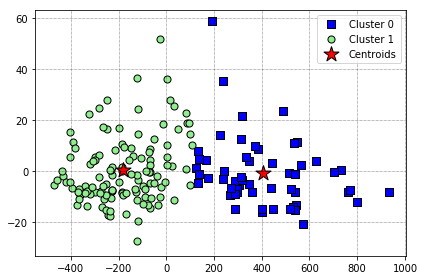

2

In [21]:
auto_km(wines)

# 4.2. Circle of Correlations Function
- Input = Dataset
- Output = PCA circles of correlation for all pairs of PCs, Plots all circles

In [24]:
def auto_pca(data):
    
    # import packages
    # ***The packages have already been imported in the previous items***
    # ***Thus we considered adequate not to put them again inside the function***
   
    # PCA analysis
    # ***2 dimensions***
    my_pca = PCA(n_components=wines.shape[1])
    new_projected_data = my_pca.fit_transform(data)
    PCs = my_pca.components_
    
    
    # Use quiver to generate the basic plot
    Done = [] #list to avoid reiteration of couples

    for num1 in range(len(PCs) - 1):
        for num2 in range(len(PCs)):
            if num1 != num2:
                if not num2 in Done:
                    fig = plt.figure(figsize=(3,3))
                    plt.quiver(np.zeros(PCs.shape[1]), 
                               np.zeros(PCs.shape[1]),
                               PCs[num1,:], PCs[num2,:], 
                               angles='xy', scale_units='xy', scale=1)

                    # Add unit circle
                    circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='g', linewidth=2)
                    plt.gca().add_artist(circle)
                    
                    # Ensure correct aspect ratio and axis limits
                    plt.axis('equal')
                    plt.xlim([-1.2,1.2])
                    plt.ylim([-1.2,1.2])

                    # Other stuff
                    plt.xlabel('PC ' + str(num1+1))
                    plt.ylabel('PC ' + str(num2+1))
                    plt.grid(color='black', linestyle=':', linewidth=0.5)
                    plt.title('Principal Components {num1} and {num2}'.format(num1=num1+1, num2=num2+1))
                    plt.show()
                    plt.close()
    
                    #avoid reiteration
                    Done.append(num1)

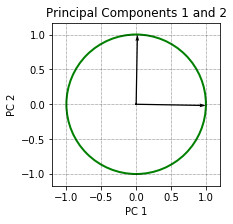

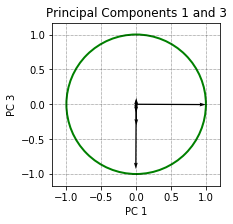

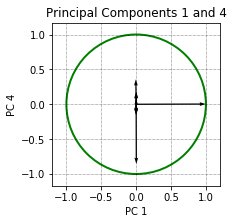

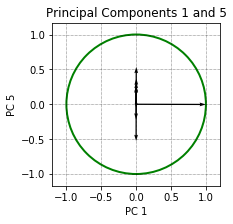

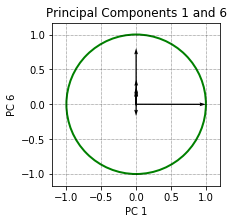

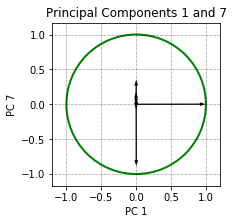

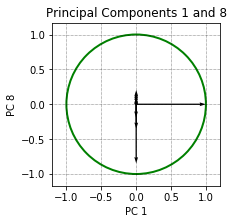

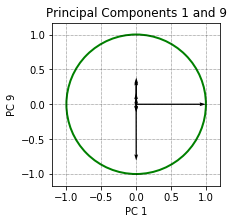

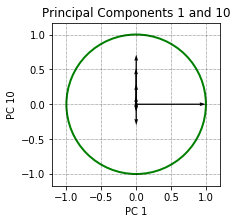

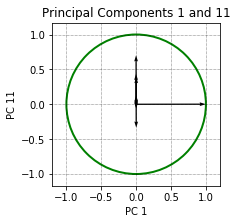

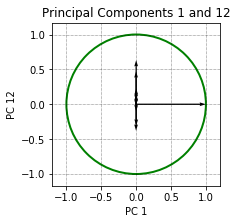

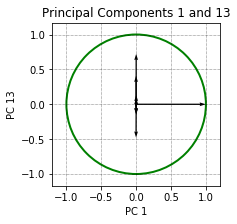

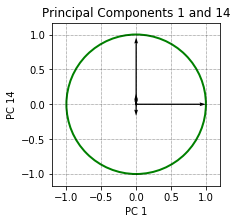

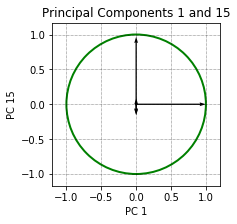

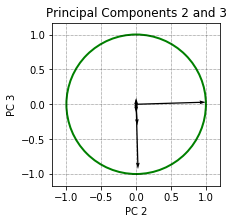

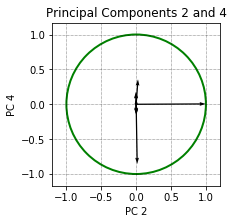

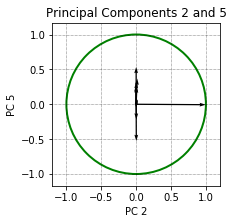

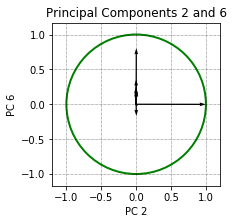

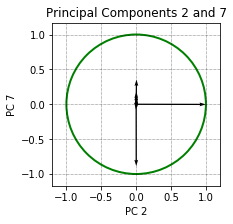

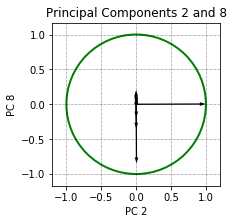

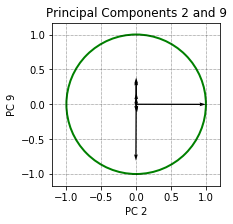

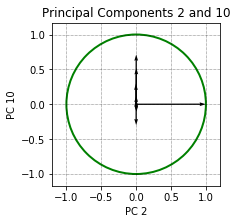

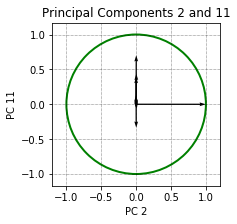

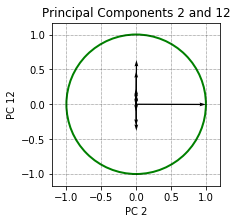

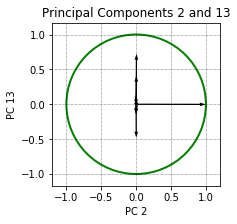

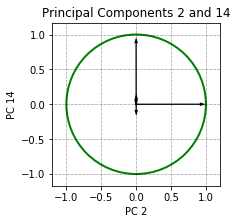

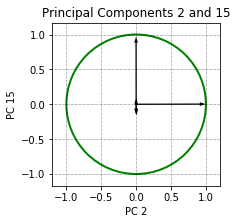

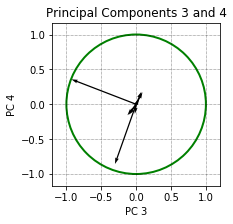

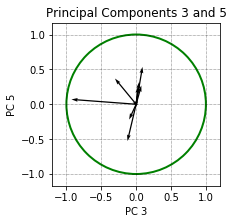

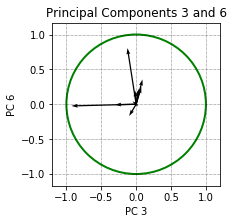

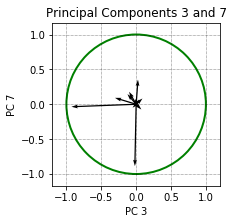

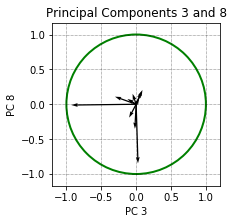

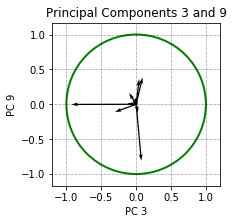

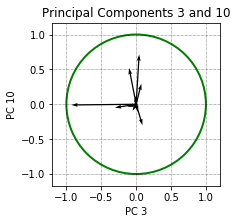

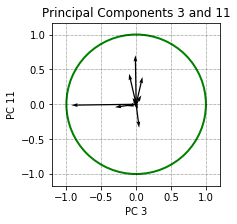

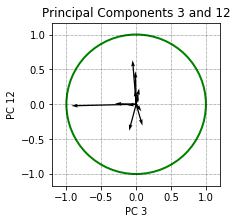

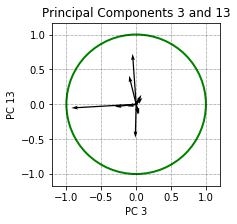

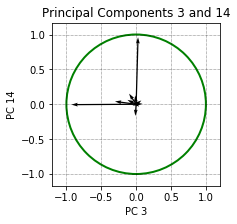

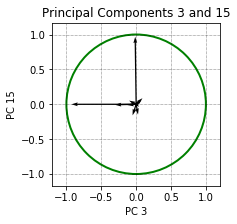

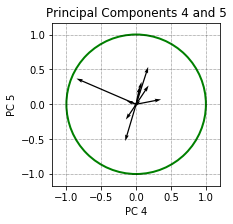

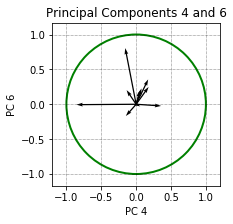

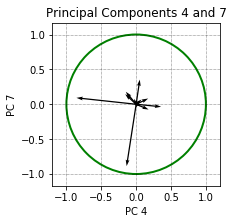

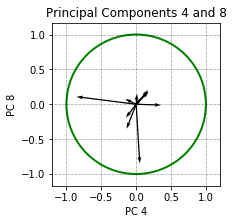

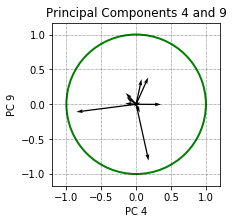

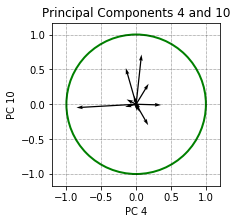

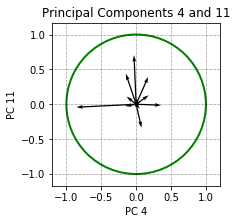

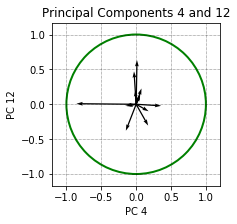

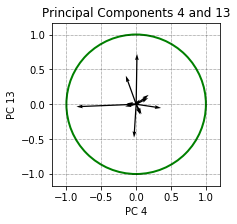

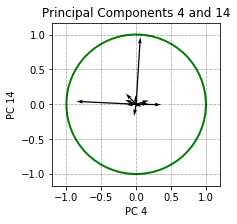

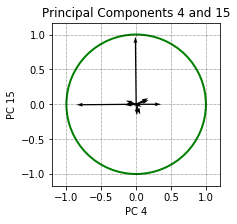

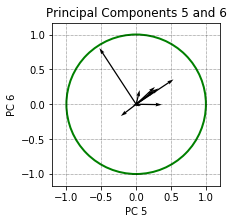

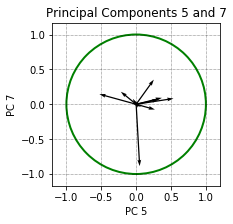

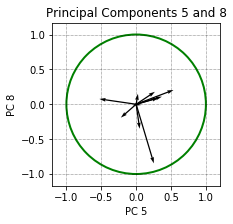

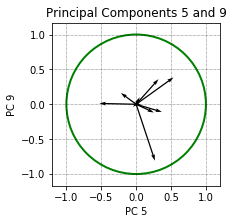

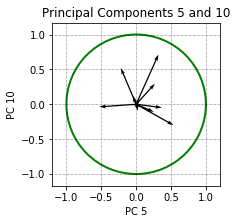

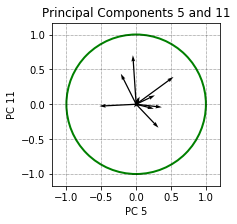

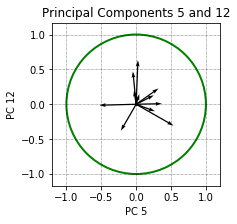

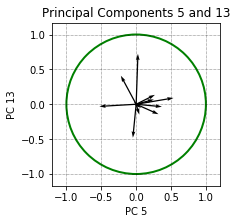

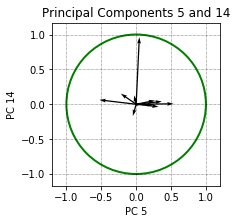

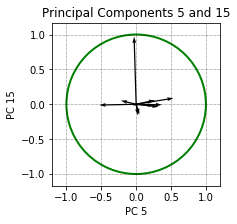

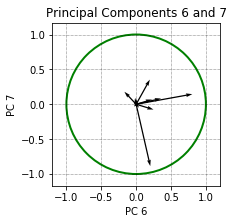

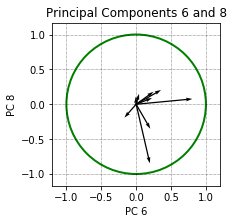

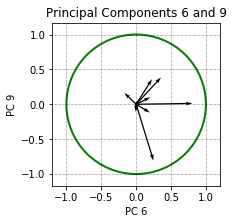

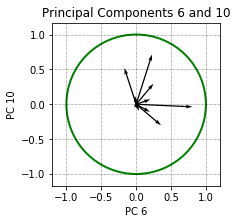

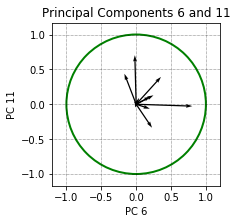

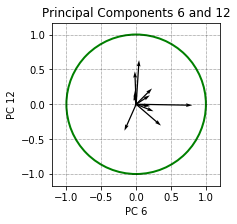

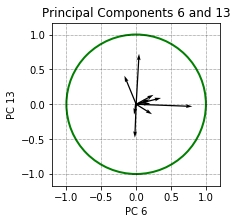

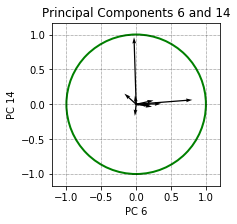

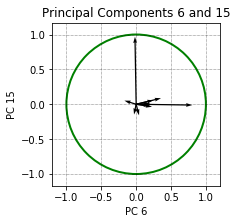

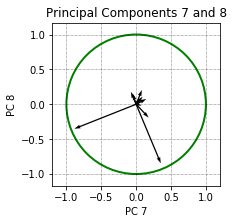

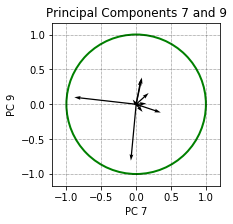

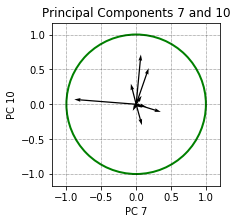

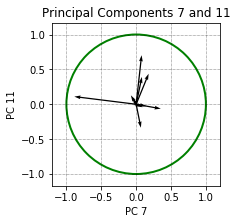

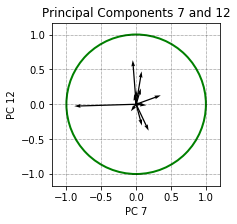

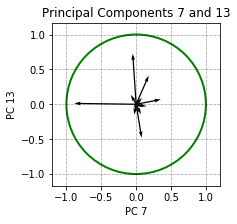

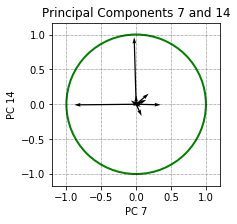

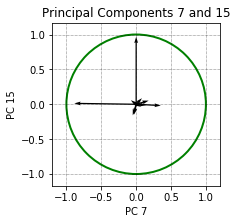

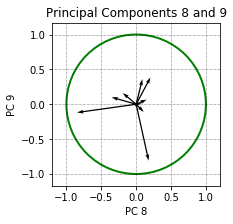

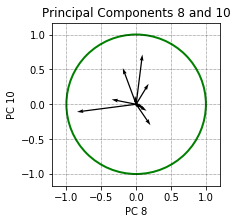

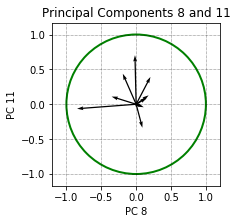

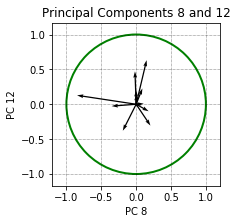

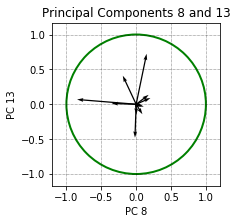

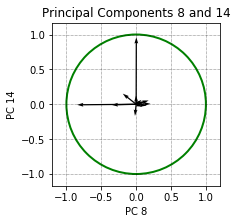

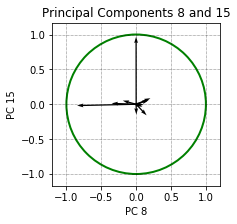

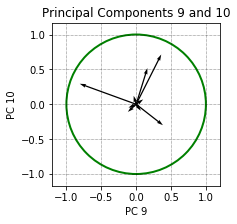

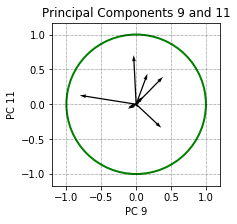

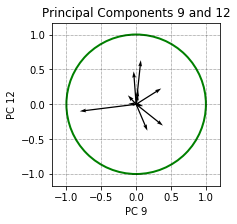

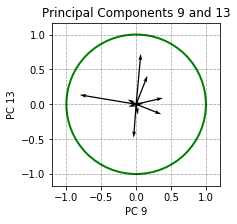

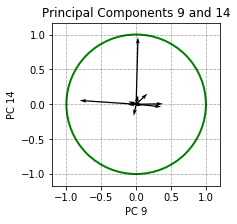

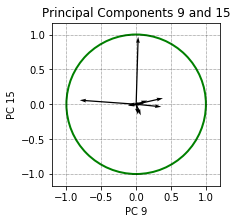

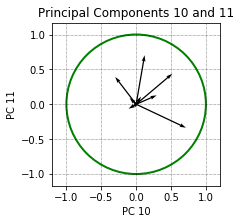

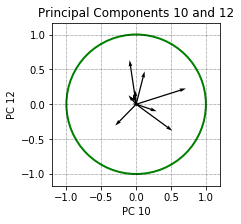

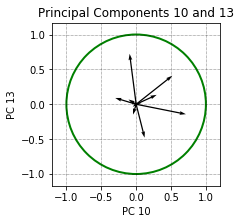

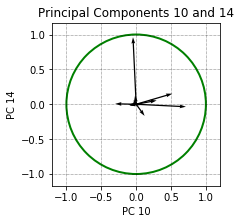

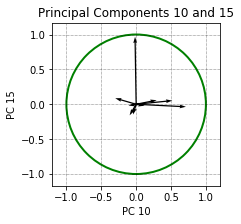

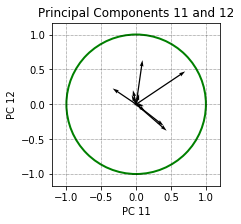

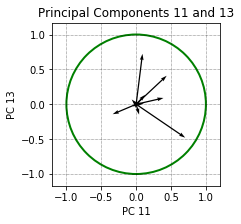

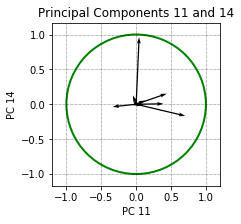

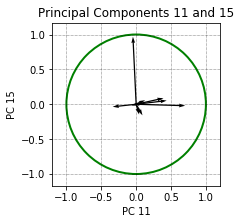

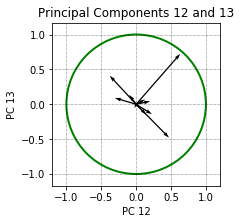

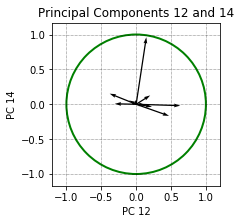

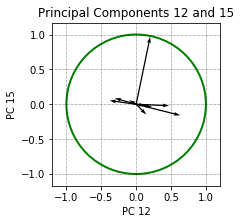

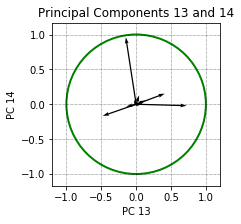

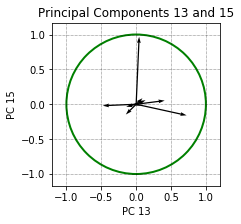

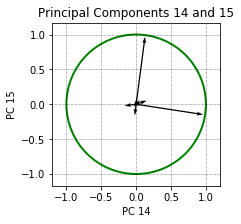

In [25]:
auto_pca(wines)